In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [11]:
with open("../configs/config.json", "r") as f:
    config = json.load(f)

input_dim = config["input_dim"]
num_classes = config["num_classes"]
train_batch_size = config["train_batch_size"]
eval_batch_size = config.get("eval_batch_size", train_batch_size)
epochs = config["epochs"]
learning_rate = config["learning_rate"]
dataset_path = config["dataset_path"]
save_model_path = config["save_model_path"]

In [12]:
class Hawkeye(nn.Module):
    def __init__(self, input_dim=4, num_classes=15):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        x = self.classifier(x)
        return x

class HawkeyeRegression(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, num_blocks=3, dropout=0.2):
        super().__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        blocks = []
        for _ in range(num_blocks):
            blocks.append(nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ))
        self.blocks = nn.Sequential(*blocks)
        self.output_layer = nn.Linear(hidden_dim, 1)  # 输出为单个连续值

    def forward(self, x):
        x = self.input_layer(x)
        x = self.blocks(x)
        x = self.output_layer(x)
        return x.squeeze(-1)  # shape: [batch]，去除最后一维

In [13]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct, total = 0, 0, 0
    for batch in tqdm(dataloader, desc="Train", leave=False):
        features = batch["features"].to(device)
        labels = batch["accept_length"].to(device)
        optimizer.zero_grad()
        indices = [14,15,17,18]
        logits = model(features[:,indices])                        
        loss = criterion(logits, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        pred = torch.round(logits)#logits.argmax(dim=1)
        total_correct += (pred == labels).sum().item()
        total += labels.size(0)
    avg_loss = total_loss / total
    acc = total_correct / total
    return avg_loss, acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Eval", leave=False):
            indices = [14,15,17,18]
            features = batch["features"].to(device)     
            labels = batch["accept_length"].to(device)
            logits = model(features[:,indices])              
            loss = criterion(logits, labels.float())
            total_loss += loss.item() * labels.size(0)
            pred = torch.round(logits)#logits.argmax(dim=1)
            total_correct += (pred == labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / total
    acc = total_correct / total
    return avg_loss, acc

In [14]:
from datasets import load_from_disk

dataset = load_from_disk(dataset_path)

In [15]:
# dataset = dataset.remove_columns([
#     "last_hidden_state", "all_hidden_state", "egale_1st_forward_hidden", "eagle_input", "last_logit", "egale_1st_forward_logit"
# ])

# dataset.set_format(type="torch", columns=["features", "accept_length"])

dataset.set_format(type="torch", columns=["features", "accept_length"])

train_set = dataset["train"]
test_set = dataset["test"]
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=eval_batch_size, shuffle=False, num_workers=2)


In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['features', 'accept_length'],
        num_rows: 6402
    })
    test: Dataset({
        features: ['features', 'accept_length'],
        num_rows: 1601
    })
})

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HawkeyeRegression(input_dim=input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

Epoch 1 | Train Loss: 43.0881 Acc: 0.0373 | Test Loss: 43.3777 Acc: 0.0231


Epoch 2 | Train Loss: 38.7633 Acc: 0.0472 | Test Loss: 40.0717 Acc: 0.0500


Epoch 3 | Train Loss: 35.1255 Acc: 0.0606 | Test Loss: 32.8812 Acc: 0.0500


Epoch 4 | Train Loss: 31.9157 Acc: 0.0681 | Test Loss: 32.9762 Acc: 0.0650


Epoch 5 | Train Loss: 28.9035 Acc: 0.0787 | Test Loss: 29.5426 Acc: 0.0693


Epoch 6 | Train Loss: 26.3693 Acc: 0.0901 | Test Loss: 28.4163 Acc: 0.0762


Epoch 7 | Train Loss: 23.8695 Acc: 0.1014 | Test Loss: 26.8735 Acc: 0.0775


Epoch 8 | Train Loss: 21.4793 Acc: 0.1059 | Test Loss: 21.7385 Acc: 0.1112


Epoch 9 | Train Loss: 19.5980 Acc: 0.1134 | Test Loss: 20.5359 Acc: 0.1143


Epoch 10 | Train Loss: 17.9905 Acc: 0.1181 | Test Loss: 19.8771 Acc: 0.1305


Epoch 11 | Train Loss: 16.5555 Acc: 0.1242 | Test Loss: 17.7773 Acc: 0.1318


Epoch 12 | Train Loss: 15.4392 Acc: 0.1215 | Test Loss: 16.3202 Acc: 0.1324


Epoch 13 | Train Loss: 14.3281 Acc: 0.1139 | Test Loss: 14.6226 Acc: 0.1274


Epoch 14 | Train Loss: 13.6569 Acc: 0.1164 | Test Loss: 14.5047 Acc: 0.1187


Epoch 15 | Train Loss: 13.0055 Acc: 0.1182 | Test Loss: 13.3805 Acc: 0.1087


Epoch 16 | Train Loss: 12.4831 Acc: 0.1098 | Test Loss: 13.4879 Acc: 0.1099


Epoch 17 | Train Loss: 12.2389 Acc: 0.1081 | Test Loss: 13.2309 Acc: 0.1093


Epoch 18 | Train Loss: 11.9733 Acc: 0.1118 | Test Loss: 12.3485 Acc: 0.1131


Epoch 19 | Train Loss: 11.7840 Acc: 0.1051 | Test Loss: 11.7165 Acc: 0.1099


Epoch 20 | Train Loss: 11.7465 Acc: 0.1043 | Test Loss: 12.1071 Acc: 0.1081
Best Test Acc: 0.13241723922548407
Best model saved to: ../../weights/hawkeye/mt-bench-llama3-d13-topk10-t0.pt


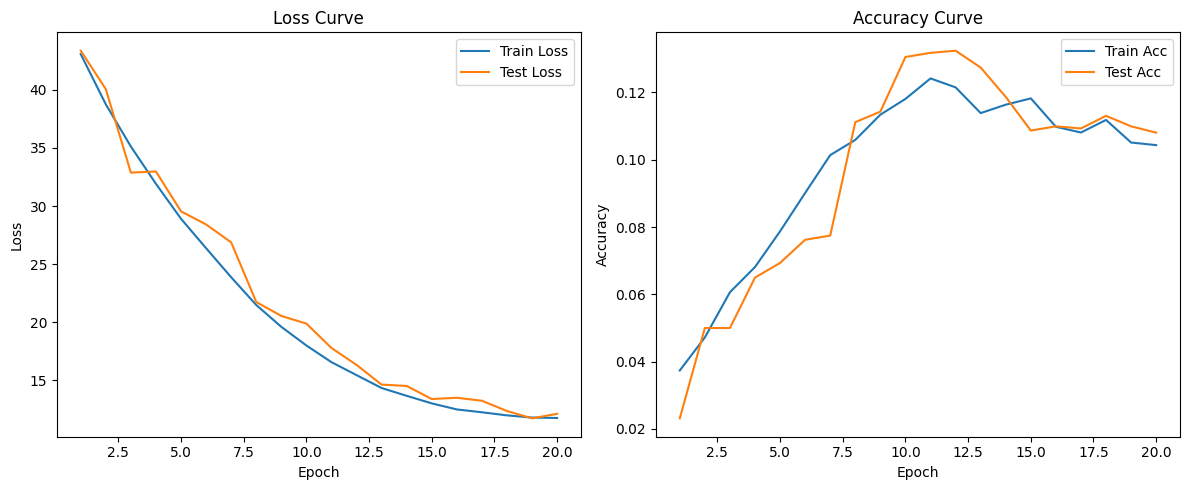

In [18]:
best_acc = 0.0
train_losses, train_accs, test_losses, test_accs = [], [], [], []

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")
    # 记录
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), save_model_path)  # 确认save_model_path为字符串
print("Best Test Acc:", best_acc)
print(f"Best model saved to: {save_model_path}")

# 绘制训练&验证曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accs, label="Train Acc")
plt.plot(range(1, epochs + 1), test_accs, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.tight_layout()
plt.savefig("train_val_curve.png")
plt.show()

## 使用scores做二元预测

In [1]:
import datasets
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
# ============ 数据处理 ============= #
# 加载数据
index = 4
dataset = datasets.load_from_disk("../data/scores/mt-bench-llama3-d7-topk10-t1")
dataset = dataset.map(lambda x: {f"eagle_{index}_label": 1 if x["accept_length"] > index else 0})

train_data = dataset["train"]
test_data = dataset["test"]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

Map:   0%|          | 0/77 [00:00<?, ? examples/s]

In [3]:
dataset["train"].select(range(10))[:]["accept_length"]

[0, 8, 7, 8, 0, 0, 8, 3, 4, 0]

In [5]:
class Eagle2Dataset(Dataset):
    def __init__(self, data, index=2):
        self.features = np.array([x[f"eagle_{index}_forward"] for x in data], dtype=np.float32)
        self.labels = np.array([x[f"eagle_{index}_label"] for x in data], dtype=np.int64)
        self.acclen = np.array([x["accept_length"] for x in data], dtype=np.int64)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.features[idx]), torch.tensor(self.labels[idx]), torch.tensor(self.acclen[idx])

train_set = Eagle2Dataset(train_data, index)
test_set = Eagle2Dataset(test_data, index)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256)

# ========== 模型定义 =========== #
class MLPClassifier(nn.Module):
    def __init__(self, topk=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(topk, 32),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
    def forward(self, x):
        return self.net(x)

In [70]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = MLPClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.9, patience=20, verbose=True)

Epoch 1  Train Loss: 0.8038  Test accuracy: 0.8701
Current LR: 0.0001500946352969992
Epoch 2  Train Loss: 0.8007  Test accuracy: 0.8701
Current LR: 0.0001500946352969992
Epoch 3  Train Loss: 0.8036  Test accuracy: 0.8701
Current LR: 0.0001500946352969992
Epoch 4  Train Loss: 0.8026  Test accuracy: 0.8571
Current LR: 0.0001500946352969992
Epoch 5  Train Loss: 0.8062  Test accuracy: 0.8571
Current LR: 0.0001500946352969992
Epoch 6  Train Loss: 0.8041  Test accuracy: 0.8571
Current LR: 0.0001500946352969992
Epoch 7  Train Loss: 0.7993  Test accuracy: 0.8571
Current LR: 0.0001500946352969992
Epoch 8  Train Loss: 0.8030  Test accuracy: 0.8571
Current LR: 0.0001500946352969992
Epoch 9  Train Loss: 0.8017  Test accuracy: 0.8701
Current LR: 0.0001500946352969992
Epoch 10  Train Loss: 0.8030  Test accuracy: 0.8701
Current LR: 0.0001500946352969992
Epoch 11  Train Loss: 0.8030  Test accuracy: 0.8701
Current LR: 0.0001500946352969992
Epoch 12  Train Loss: 0.8036  Test accuracy: 0.8571
Current LR:

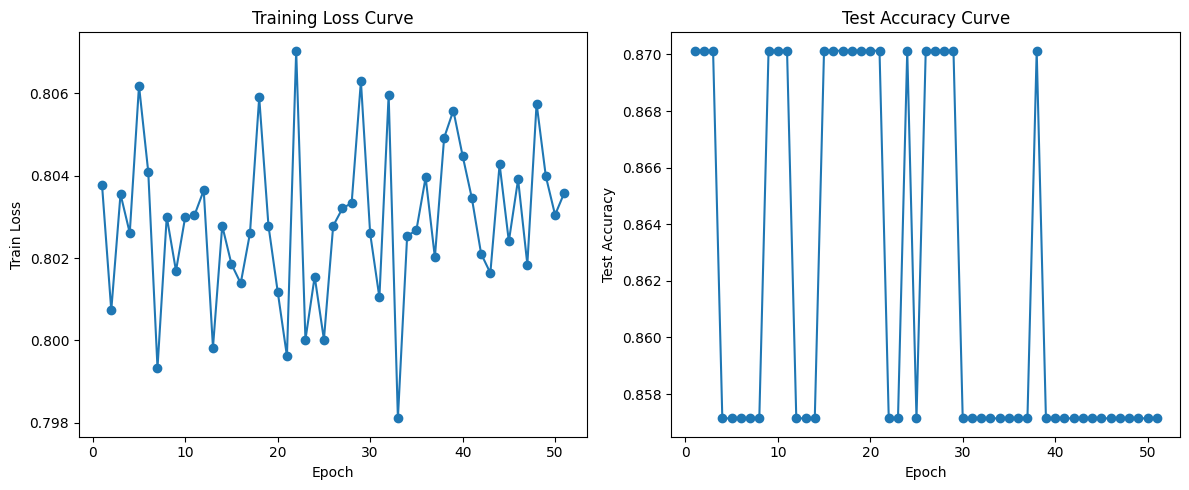

In [77]:
# 记录训练过程
train_losses = []
test_accuracies = []
best_acc = 0
patience = 50
no_improve = 0

def dis(logits, accl, scale=8.0):
    """
    logits: [batch, 2]
    accl: [batch] (accept_length, int)
    scale: 控制平滑程度，8.0时最大为1
    """
    continue_prob = F.softmax(logits, dim=1)[:, 0]
    target = torch.clamp((accl.float() - 2) / scale, 0, 1)  # 归一化到0~1
    return F.mse_loss(continue_prob, target)

for epoch in range(200):
    # 训练
    model.train()
    epoch_loss = 0
    for xb, yb, accl in train_loader:
        xb, yb, accl = xb.to(device), yb.to(device), accl.to(device)
        logits = model(xb)
        loss = criterion(logits, yb) + 1 * dis(logits, accl)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    train_losses.append(epoch_loss / len(train_set))
    # 验证
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb ,_ in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            pred = logits.argmax(dim=1).cpu().numpy()
            y_pred.extend(pred)
            y_true.extend(yb.numpy())
    acc = accuracy_score(y_true, y_pred)
    test_accuracies.append(acc)
    print(f"Epoch {epoch+1}  Train Loss: {train_losses[-1]:.4f}  Test accuracy: {acc:.4f}")
    print(f"Current LR: {optimizer.param_groups[0]['lr']}")
    scheduler.step(acc)
    # Early stopping
    if acc > best_acc:
        best_acc = acc
        no_improve = 0
        torch.save(model.state_dict(), f"../../weights/hawkeye/best_eagle_{index}_model.pt")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping.")
            break

print(f"Best Test Accuracy: {best_acc:.4f}")

# === 可视化训练过程 ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Training Loss Curve')
plt.subplot(1,2,2)
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Curve')
plt.tight_layout()
plt.show()

In [4]:
label = dataset["train"][:][f"eagle_{index}_label"]
positive = sum(label)
print(positive)
print(positive/len(label))

61
0.19805194805194806
